### Outlier Factors for Device Profiling

TODO

For this first part of the presentation, we will be using data in the form of (timestamp, source computer, number of bytes) where each data point represents a data flow. Data will be binned and so two different features will be extracted per source computer, per bin. That is count of flows and average number of flows per bin.

For testing purposes a generated dataset will be used.

From these flows per user, we can generate the features count and average byte count.

Next we will display the in a scatter plot the points generated

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

number_of_hosts = 5
time_limits = [1,10]

df = pd.read_csv('../../../diploma/generated_data/flows.txt', header=None)

df.columns = ['time', 'source computer', 'byte count']

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.sort_index(inplace=True)
df.head()

,source computer,byte count
time,,
1,C0,188
1,C4,70
1,C4,107
1,C3,527
1,C3,537


For better illustration we will plot these points in a two dimensional grid

In the following we plot the for each host the flows per bin and after temporal bins format.

In [2]:
# keep track of the different host TODO

hosts = np.array(list(set(df['source computer'].values)))
hosts.sort()

# Create buckets based on the time of the events, a bucker for every size_of_bin_seconds seconds

size_of_bin_seconds = 1
bins = np.arange(df.index.min(), df.index.max() + size_of_bin_seconds + 1, size_of_bin_seconds)
print('The borders of the bins created: ', bins)

The borders of the bins created:  [ 1  2  3  4  5  6  7  8  9 10 11]


In this ty example we create a bin for each time index. In the final dataset this will correspond to a bin every second

In [3]:
# group by the correct bin and the source computer

groups = df[['byte count','source computer']].groupby([np.digitize(df.index, bins),'source computer'])

mean_values = groups.mean().values
count_values = groups.count().values

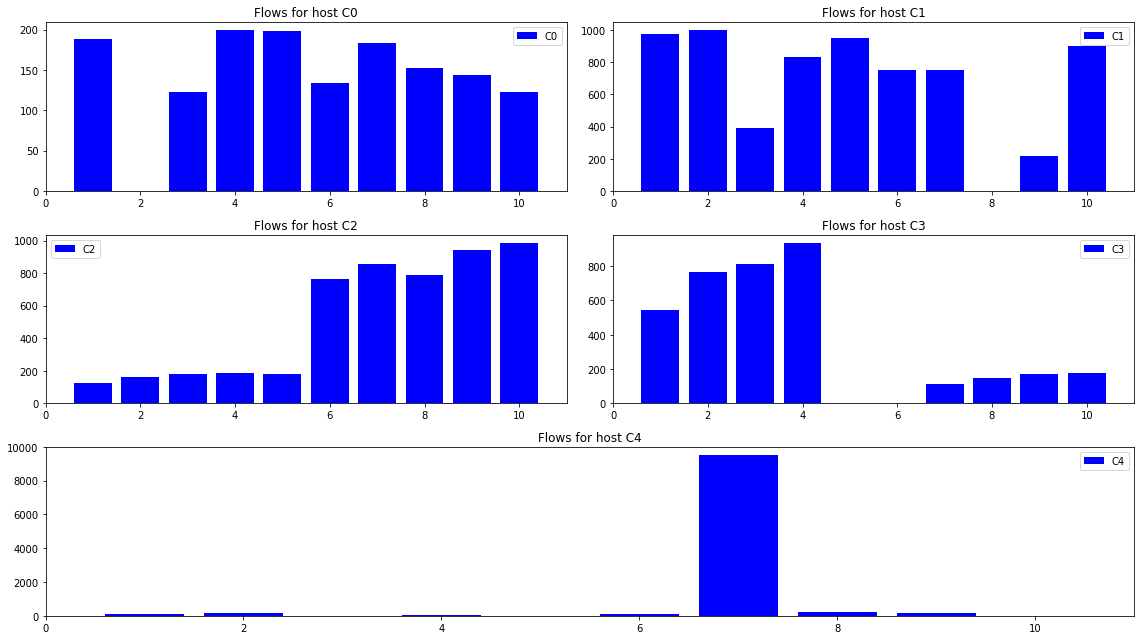

In [4]:
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

for i in range(number_of_hosts):
    if number_of_hosts % 2 == 0:
        plt.subplot(number_of_hosts/2, 2, i + 1)
    else:
        if i < number_of_hosts - 1:
            plt.subplot(int(number_of_hosts/2) + 1, 2, i + 1)
        else:
            plt.subplot(int(number_of_hosts/2) + 1, 1, int(number_of_hosts/2) + 1)

    df_for_host = df[df['source computer'].isin([hosts[i]])]
    plt.bar(df_for_host.index, df_for_host['byte count'], label=hosts[i], color='blue')

    plt.title('Flows for host ' + hosts[i])
    plt.xlim([time_limits[0] - 1, time_limits[1] + 1])
    plt.legend()
    
plt.tight_layout()
plt.show()

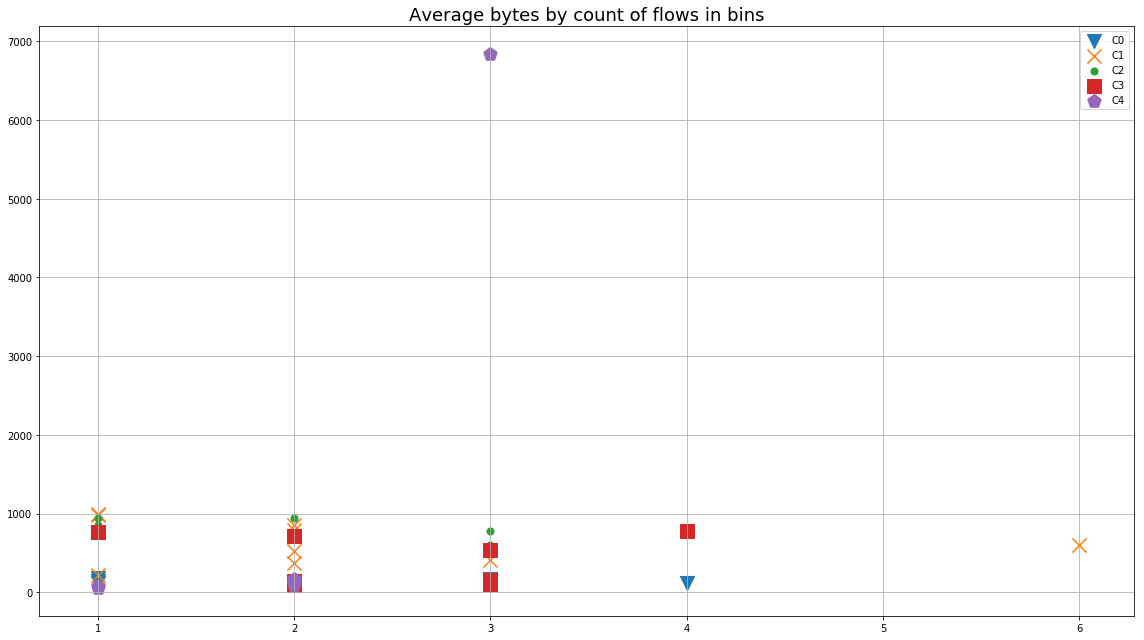

In [5]:
markers = ['v', 'x', '.', 's', 'p']

for i in range(number_of_hosts):
    filter_list = [x for x in groups.apply(lambda x:  (x['source computer'] == hosts[i]).values[0])]
    
    plt.scatter(count_values[filter_list], mean_values[filter_list], s=200, 
                marker=markers[i % len(markers)], label=hosts[i])
    
plt.title('Average bytes by count of flows in bins', fontsize=18)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Global and host - specific means

As a first naive approach we calculate the mean for each individual host and the global mean generated from these meassurements

First we preprocess the data

As all data will have a positive value we could just scale them using a simple approach:

$$log(x + 1)$$

In [6]:
data = groups.count()
data.columns = ['number of flows']
data['mean(byte count)'] = groups.mean().values

data.head()

number of flows  mean(byte count)
  source computer                                   
1 C0                             3        160.333333
  C1                             1        977.000000
  C2                             1        125.000000
  C3                             3        536.333333
  C4                             2         88.500000

In [7]:
def scale(x):
    return np.log(x + 1)

In [8]:
data_by_host = {}

for host in hosts:
    for i in range(len(bins) - 1):
        try:
            values = scale(data.loc[(i + 1, host)].values)
        except:
            values = scale(np.array([0, 0]))
        if i == 0:
            data_by_host[host] = np.array([values])
        else:
            data_by_host[host] = np.append(data_by_host[host], np.array([values]), axis=0)

Perhaps the log function will "hide" potential outliers and will not be a good match for the metric distance used later.
Instead we will use a standard 

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# to all data append [0, 0] so that [0, 0] is the mapped to [0, 0] with our new scaler
scaler.fit(np.append(data.values, np.array([[0, 0]]), axis=0))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
data_by_host = {}

for host in hosts:
    for i in range(len(bins) - 1):
        try:
            values = scaler.transform([data.loc[(i + 1, host)].values])
        except:
            values = scaler.transform([np.array([0, 0])])
        if i == 0:
            data_by_host[host] = np.array(values)
        else:
            data_by_host[host] = np.append(data_by_host[host], np.array(values), axis=0)

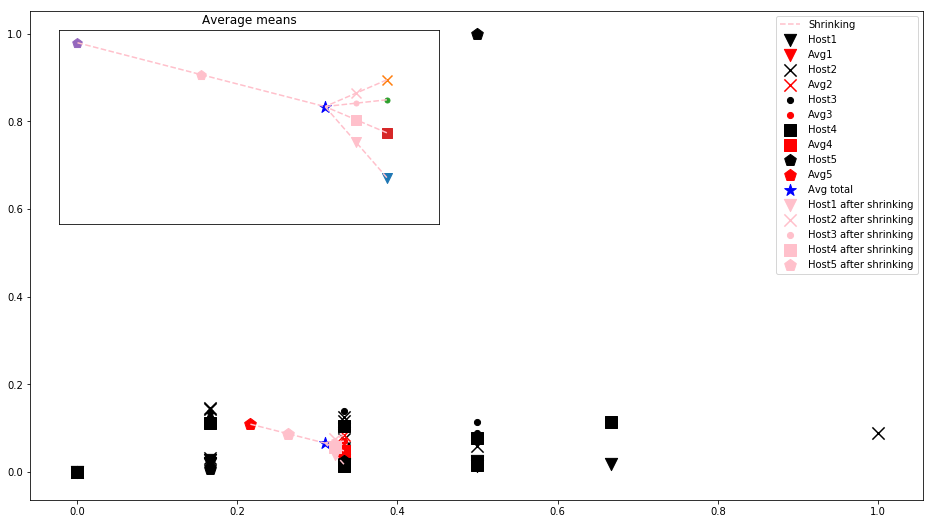

In [11]:
# the shrinkage
shrinkage = 0.5

i = 0
means = []
for host, data_for_host in data_by_host.items():
    # two features used
    x = data_for_host[:,0]
    y = data_for_host[:,1]
    plt.scatter(x, y, marker=markers[i % len(markers)], s=150, color='black', label='Host' + str(i + 1))
    mean_x = sum(x)/len(x)
    mean_y = sum(y)/len(y)
    means.append([mean_x, mean_y])
    
    plt.scatter(mean_x, mean_y, marker=markers[i % len(markers)], s=150, color='red', label='Avg' + str(i + 1))
    i += 1
    if i == number_of_hosts:
        break

global_mean = [float(sum(col))/len(col) for col in zip(*means)]

plt.scatter(global_mean[0], global_mean[1], marker='*', s=150, color='blue', label='Avg total')

i = 0
for mean in means:
    if i == 0:
        plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', label='Shrinking', color='pink')
    else:
        plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', color='pink')
    i += 1

i = 0
for mean in means:
    shrinked = np.array(mean) * (1 - shrinkage) + np.array(global_mean) * shrinkage
    plt.scatter(shrinked[0], shrinked[1], marker=markers[i % len(markers)], s=150, color='pink', label='Host' + str(i + 1) + ' after shrinking')
    i += 1

plt.legend()


# this is an inset axes over the main axes
plt.axes([.15, .55, .33, .3])
for i, mean in enumerate(means):
    plt.scatter(mean[0], mean[1], marker=markers[i % len(markers)], s=100)
    plt.plot([mean[0], global_mean[0]], [mean[1], global_mean[1]], '--', color='pink')
    
    shrinked = np.array(mean) * (1 - shrinkage) + np.array(global_mean) * shrinkage
    plt.scatter(shrinked[0], shrinked[1], marker=markers[i % len(markers)], color='pink', s=100)
    
plt.scatter(global_mean[0], global_mean[1], marker='*', s=150, color='blue')

plt.title('Average means')
plt.xticks([])
plt.yticks([])


plt.show()

First we will attempt a naive clustering of these points

In [12]:
import itertools

all_data = list(itertools.chain(*list(data_by_host.values())))

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(all_data)

print(kmeans.cluster_centers_)

[[ 0.10526316  0.04211553]
 [ 0.43548387  0.08067899]]


A possible error that can occur is if the number of clusters in high and anomalies are similar, clusters may be formed around the anomalies.

This can probably be accpted

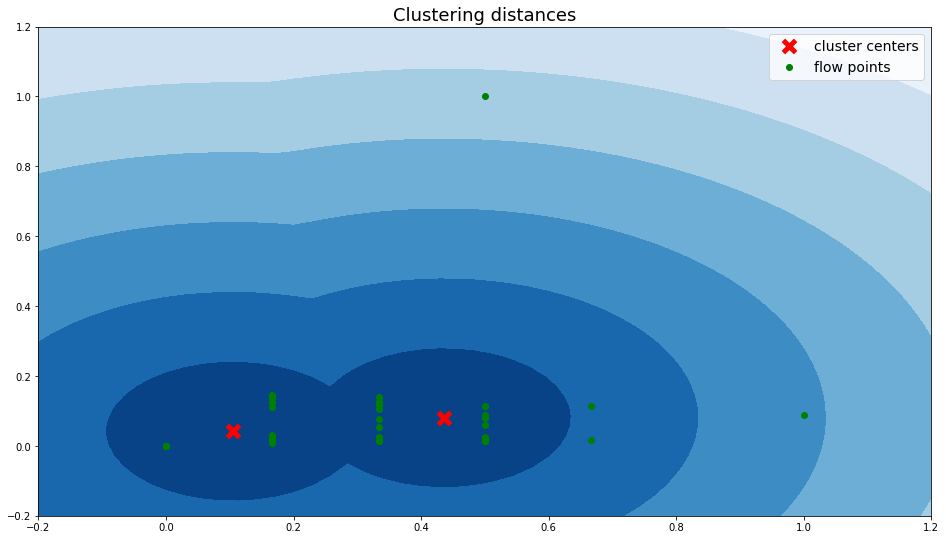

In [14]:
def distance_to_closest_cluster(X, kmeans):
    distances = kmeans.transform(X)
    return np.min(distances, axis=1)

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 50), np.linspace(-0.2, 1.2, 50))
#Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = distance_to_closest_cluster(np.c_[xx.ravel(), yy.ravel()], kmeans)
Z = Z.reshape(xx.shape)

plt.title("Clustering distances", fontsize=18)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

for center in kmeans.cluster_centers_:
    a = plt.scatter(center[0], center[1], color='red', marker='x', s=150, linewidth=5)
    
for point in all_data:
    b = plt.scatter(point[0], point[1], color='green', marker='o') 

plt.axis('tight')
plt.xlim(-0.2,1.2)
plt.ylim(-0.2,1.2)
plt.legend([a, b], ["cluster centers","flow points"], fontsize=14)
plt.show()

For the rest of this excercise we will be using the dataset provided at https://csr.lanl.gov/data/cyber1/ 

From the file flows.txt the first 100,000 lines will be initially used

In [15]:
N = 50000

df_N = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=N)

In [16]:
df_N.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df_N.index = df_N['time']
df_N.drop(columns=['time'],inplace=True)
df_N.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [17]:
from sklearn.preprocessing import MinMaxScaler

def scale(x):
    return np.log(x + 1)

def get_data_by_dataframe(df, size_of_bin_seconds=50, doScale=True):
    """
    :param size_of_bin_seconds: the time period of each bin,
                assumes the dataframe has a column names 'source computer' and a name 'byte count'
    :return: a dictionary containing for each host the features, the hosts 
    """
    hosts = np.array(list(set(df['source computer'].values)))
    
    bins = np.arange(df.index.min(), df.index.max() + size_of_bin_seconds + 1, size_of_bin_seconds)
    
    groups = df[['byte count','source computer']].groupby([np.digitize(df.index, bins),'source computer'])

    data = groups.count()
    data.columns = ['number of flows']
    data['mean(byte count)'] = groups.mean().values
    
    """
    scaler = MinMaxScaler()
    
    # to all data append [0, 0] so that [0, 0] is the mapped to [0, 0] with our new scaler
    scaler.fit(np.append(data.values, np.array([[0, 0]]), axis=0))
    """
    data_by_host = {}
     
    for host in hosts:
        for i in range(len(bins) - 1):
            try:
                if doScale == True:
                    values = scale(data.loc[(i + 1, host)].values)
                else:
                    values = data.loc[(i + 1, host)].values
            except:
                if doScale == True:
                    values = scale(np.array([0, 0]))
                else:
                    values = np.array([0, 0])
                    
            if i == 0:
                data_by_host[host] = np.array([values])
            else:
                data_by_host[host] = np.append(data_by_host[host], np.array([values]), axis=0)
                
    return data_by_host, hosts

data_by_host_N, hosts_N = get_data_by_dataframe(df_N)

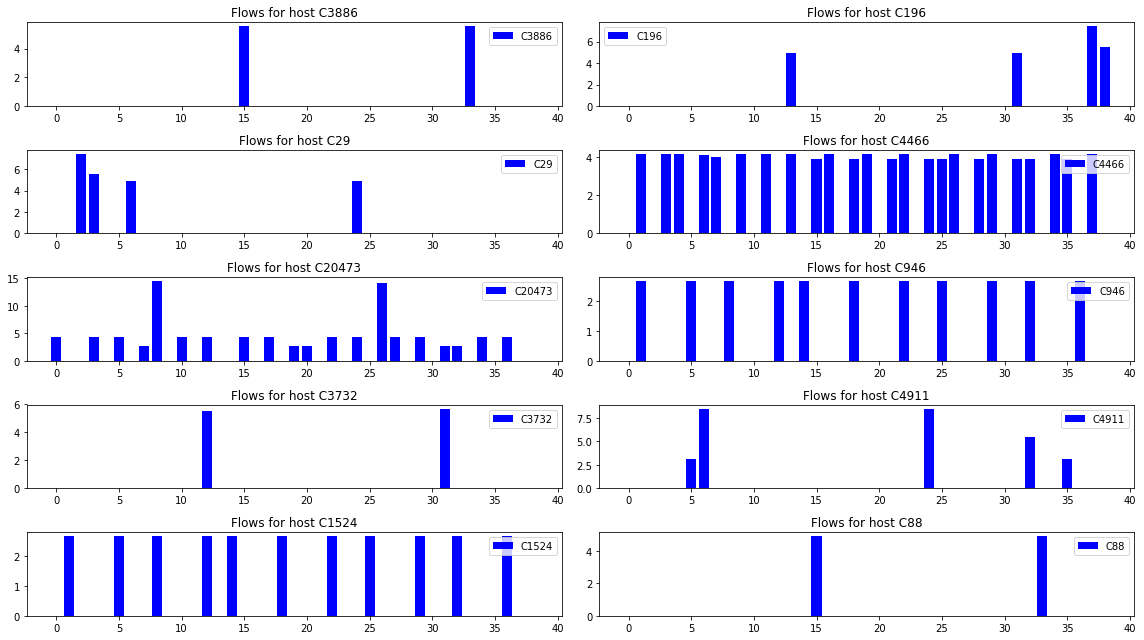

In [18]:
def plot_host_behavior(data_by_host, hosts):
    number_of_hosts = len(hosts)
    for i in range(number_of_hosts):
        if number_of_hosts % 2 == 0:
            plt.subplot(number_of_hosts/2, 2, i + 1)
        else:
            if i < number_of_hosts - 1:
                plt.subplot(int(number_of_hosts/2) + 1, 2, i + 1)
            else:
                plt.subplot(int(number_of_hosts/2) + 1, 1, int(number_of_hosts/2) + 1)

        data_for_host = data_by_host[hosts[i]]
        plt.bar(np.arange(len(data_for_host)), data_for_host[:,0] * data_for_host[:,1], label=hosts[i], color='blue')

        plt.title('Flows for host ' + hosts[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_host_behavior(data_by_host_N, hosts_N[40:50])

We must now consider the number of clusters into which to divide our data to

[1](https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/), [2](http://www.sthda.com/english/articles/29-cluster-validation-essentials/96-determining-the-optimal-number-of-clusters-3-must-know-methods/)

#### Elbow method

In [19]:
import itertools
from sklearn.cluster import KMeans

all_data_N = np.vstack(list(itertools.chain(*list(data_by_host_N.values()))))

In [20]:
from sklearn.metrics import silhouette_score

cluster_sizes = range(3, 10)

cluster_scores = []
silhouette_scores = []

for k in cluster_sizes:
    km = KMeans(k, random_state=77)
    km.fit(all_data_N)
    cluster_scores.append(km.inertia_)

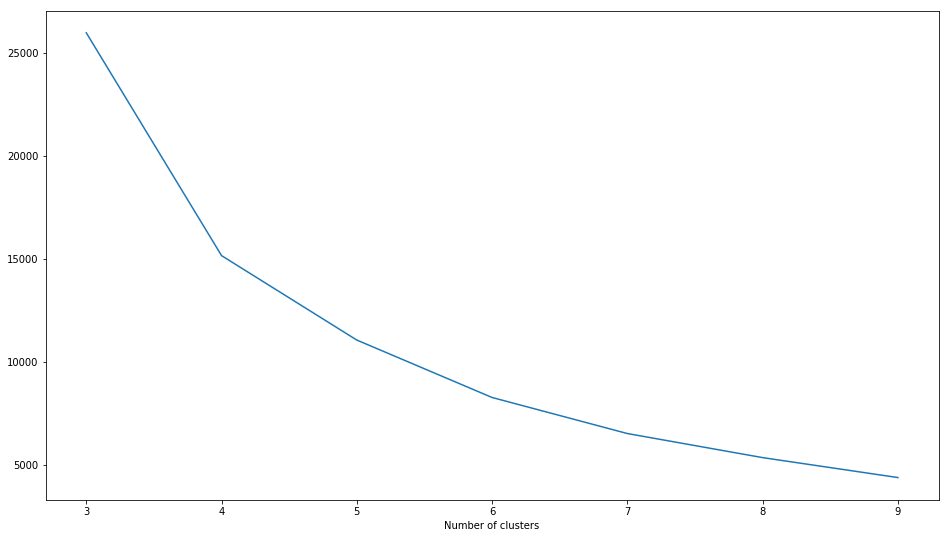

In [21]:
plt.plot(cluster_sizes, cluster_scores)
plt.xlabel('Number of clusters')
plt.show()

From the above example we could probably conclude that the best number of clusters for this dataset will be k=4

Silhouette coefficient could also be used.

Vey often it can lead to memory error due to the memory required.

For completeness display the two dimensional space created in this real dataset

In the following statistics (0, 0) values have been included if no flows have been meassured
Cluster centers
[[  1.22901689e-13  -7.76489983e-13]
 [  8.67925421e-01   4.30436142e+00]
 [  1.23548981e+00   7.46372927e+00]
 [  1.69638071e+00   1.22511758e+01]]
A total of 54096 	points have a closest cluster 0
A total of 6870 	points have a closest cluster 1
A total of 6808 	points have a closest cluster 2
A total of 515 	points have a closest cluster 3


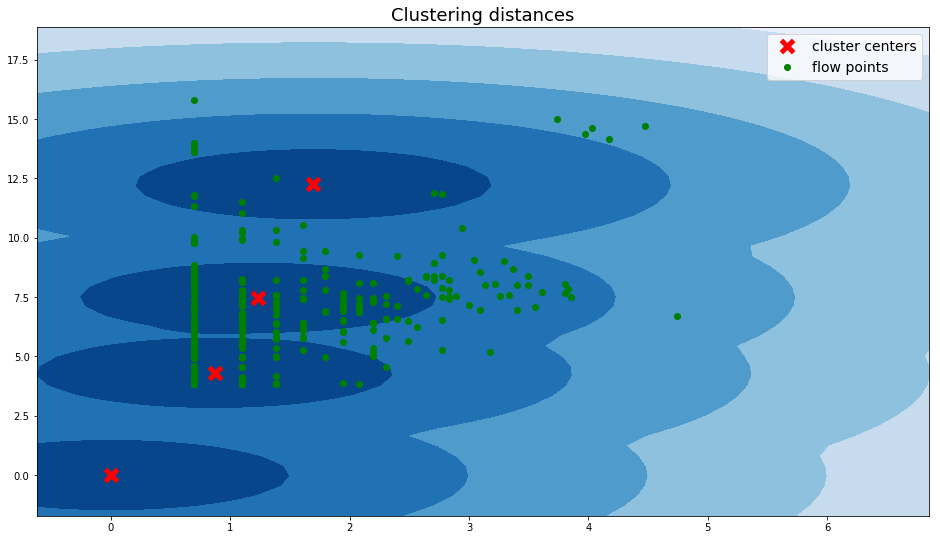

In [22]:
n_clusters = 4
kmeans_N = KMeans(n_clusters=n_clusters, random_state=0).fit(all_data_N)

print('In the following statistics (0, 0) values have been included if no flows have been meassured')
print('Cluster centers')
print(kmeans_N.cluster_centers_)

closest_cluster = kmeans_N.predict(all_data_N)

for i in range(n_clusters):
    cluster_i = np.where(closest_cluster == i)
    print('A total of', len(cluster_i[0]), '\tpoints have a closest cluster', i)


all_data_N_min = np.min(all_data_N, axis=0)
all_data_N_max = np.max(all_data_N, axis=0)
len_x = all_data_N_max[0] - all_data_N_min[0]
len_y = all_data_N_max[1] - all_data_N_min[1]
limits_x = [all_data_N_min[0] - 0.1 * len_x, all_data_N_max[0] + 0.1 * len_x]
limits_y = [all_data_N_min[1] - 0.1 * len_y, all_data_N_max[1] + 0.1 * len_y]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(limits_x[0], limits_x[1], 50), 
                     np.linspace(limits_y[0], limits_y[1], 50))
#Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = distance_to_closest_cluster(np.c_[xx.ravel(), yy.ravel()], kmeans_N)
Z = Z.reshape(xx.shape)

plt.title("Clustering distances", fontsize=18)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)


# randomly scatter some only points
choices = np.random.choice(len(all_data_N), 5000)

for choice in choices:
    point = all_data_N[choice]
    b = plt.scatter(point[0], point[1], color='green', marker='o') 
  
for center in kmeans_N.cluster_centers_:
    a = plt.scatter(center[0], center[1], color='red', marker='x', s=150, linewidth=5)
      
plt.axis('tight')
plt.xlim(limits_x)
plt.ylim(limits_y)
plt.legend([a, b], ["cluster centers","flow points"], fontsize=14)
plt.show()

To detect outlier we will be using a method similar to 

- A COMPUTER HOST-BASED USER ANOMALY DETCTION SYSTEM USING THE SELF-ORGANIZING MAP Albert J. Hoglund, Kimmo Hatonen, Antti S. Sorvari

For each data point calculate the distance to the closest cluster to it.
THen calculate the percentage of points having a larger distance to their closest cluster center.

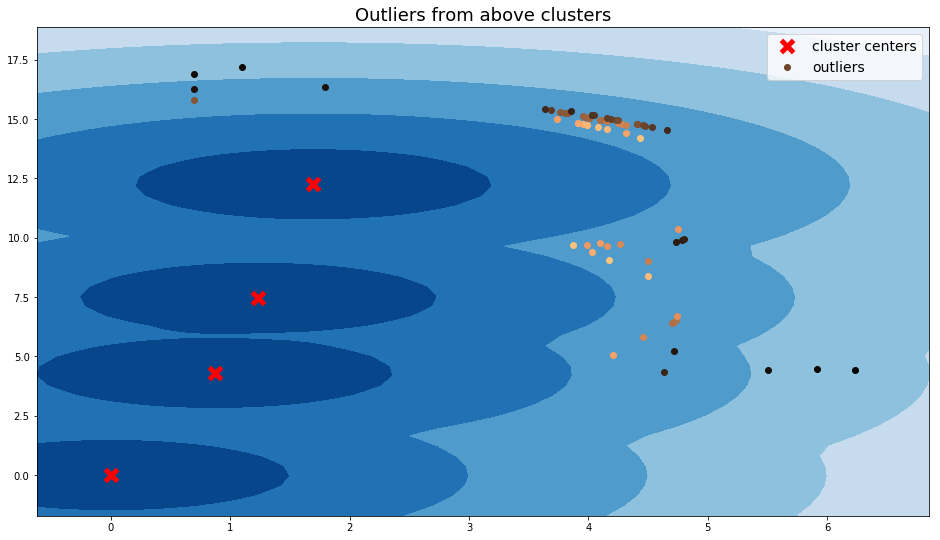

In [23]:
plt.title("Outliers from above clusters", fontsize=18)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

for center in kmeans_N.cluster_centers_:
    a = plt.scatter(center[0], center[1], color='red', marker='x', s=150, linewidth=5)
      
distances_to_closest_cluster = distance_to_closest_cluster(all_data_N, kmeans_N)
total_points = len(distances_to_closest_cluster)

Copper = plt.get_cmap('copper')

for point in all_data_N:
    test = np.where(distance_to_closest_cluster([point], kmeans_N)[0] > distances_to_closest_cluster)
    # consider an outlier if the distance to its closest cluster is bigger than a percentage compared to other points
    threshold = 0.999
    if len(test[0]) > total_points * threshold:
        b = plt.scatter(point[0], point[1], marker='o',
                        color=Copper((total_points - len(test[0])) / ((1 - threshold)*total_points))) 

plt.axis('tight')
plt.xlim(limits_x)
plt.ylim(limits_y)
plt.legend([a, b], ["cluster centers","outliers"], fontsize=14)
plt.show()

For the above examples a simple kmeans clustering is implemented

Now we will use a mixture of Poisson distributions as shown in 

Online EM algorithm for mixture with application
to internet traffic modeling

Z. Liua,∗, J. Almhanaa, V. Choulakiana, R. McGormanb

In [24]:
from onlineEM import OnlineEM

In [39]:
all_data_N_no_scale = np.vstack(np.array(list(itertools.chain(*list(data_by_host_N_no_scale.values()))), dtype=np.int64))

In [132]:
from random import randint

def get_random_initialize_lamdas(data, number_of_mixtures=4):
    mins = np.min(data, axis=0)
    maxs = np.max(data, axis=0)
    
    dims = len(mins)
    lambdas = [[] for _ in range(number_of_mixtures)]
    for i in range(dims):
        for j in range(number_of_mixtures):
            lambdas[j].append(randint(int(mins[i]), int(maxs[i])))
            
    return np.vstack(lambdas)

In [150]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(data, feature_range=(1,100)):
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler.fit(data)
    transformed = scaler.transform(data).astype(int)
    return np.array(transformed, dtype=np.int64)
    
# scale to 1 - a maximum value equal to the maximum value that can be achieved
all_data_N_rescaled = scale_data(all_data_N)

In [152]:
mixtures = 10

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, get_random_initialize_lamdas(all_data_N_rescaled, number_of_mixtures=10), 500)
onlineEM.train(all_data_N_rescaled)

In [47]:
from plots import plot_results, plot_points

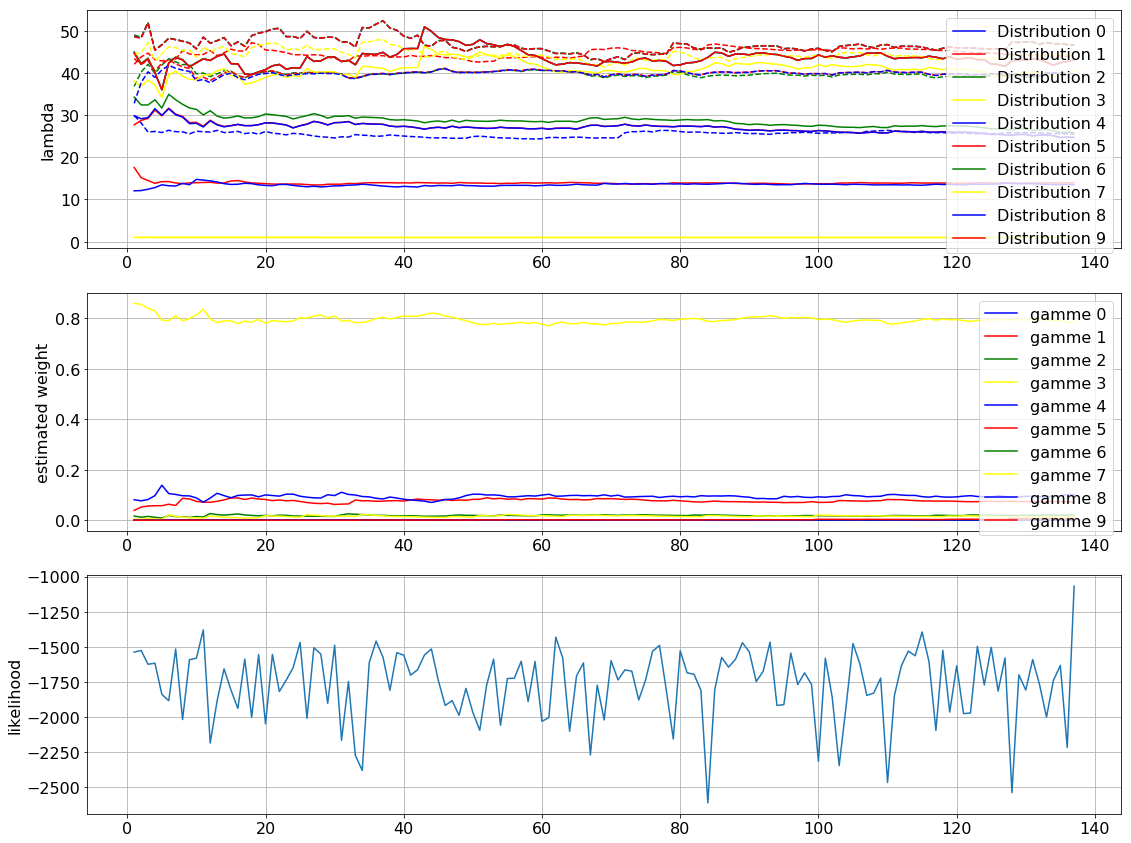

In [155]:
plot_results(onlineEM)

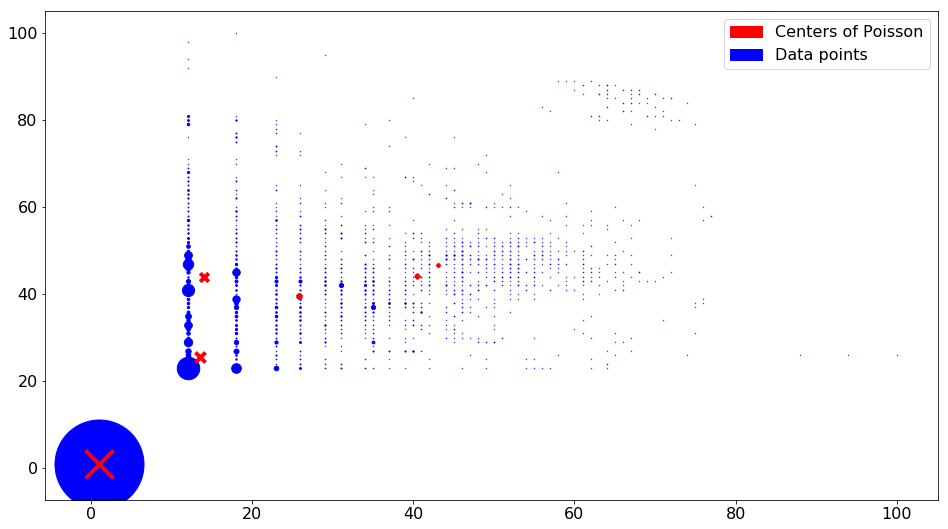

In [166]:
plot_points(all_data_N_rescaled, onlineEM)

Not all points can be represented adequately

This could be a proper issue

Some of the poissons from the mixture have a very low probability. A smaller number could be used perhaps.

In [171]:
onlineEM.gammas

array([  1.33581875e-04,   7.27858467e-02,   2.00802499e-02,
         7.83562246e-01,   1.01113005e-01,   9.07753026e-07,
         2.37117896e-04,   1.50192185e-02,   1.93601738e-07,
         7.06763291e-03])

In [174]:
mixtures = 50

# random initialization
onlineEM_50 = OnlineEM([1/mixtures]*mixtures, get_random_initialize_lamdas(all_data_N_rescaled, number_of_mixtures=50), 500)
onlineEM_50.train(all_data_N_rescaled)

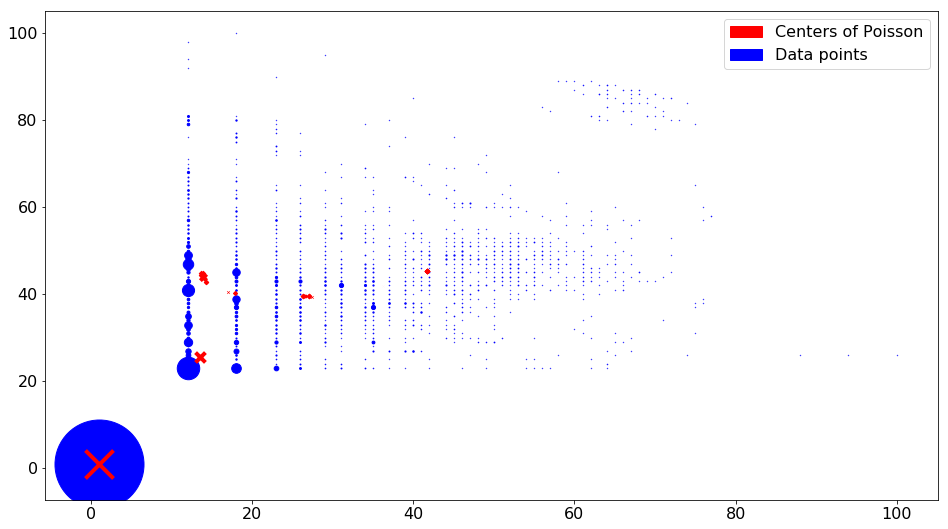

In [175]:
plot_points(all_data_N_rescaled, onlineEM_50)

As we can see adding for centers for our Poisson can be considered a failure towards represeningt more data points.

In [176]:
from sklearn.externals import joblib  
joblib.dump(onlineEM_50, 'onlineEM_50????.pkl')
joblib.dump(all_data_N, 'all_data_N????.pkl')
joblib.dump(all_data_N_rescaled, 'all_data_N_rescaled?????.pkl')

['onlineEM_50.pkl']

In [ ]:
onlineEM_50 = joblib.load('onlineEM_50.pkl')

LOF doesn't work very well

In [45]:
all_data_unique = [np.array(i) for i in set(tuple(i) for i in all_data_N)]

In [77]:
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# fit the model
clf = LocalOutlierFactor(n_neighbors=25, contamination=0.01)

y_pred = clf.fit_predict(all_data_N)

In [80]:
len(np.where(y_pred == 1)[0])

23397

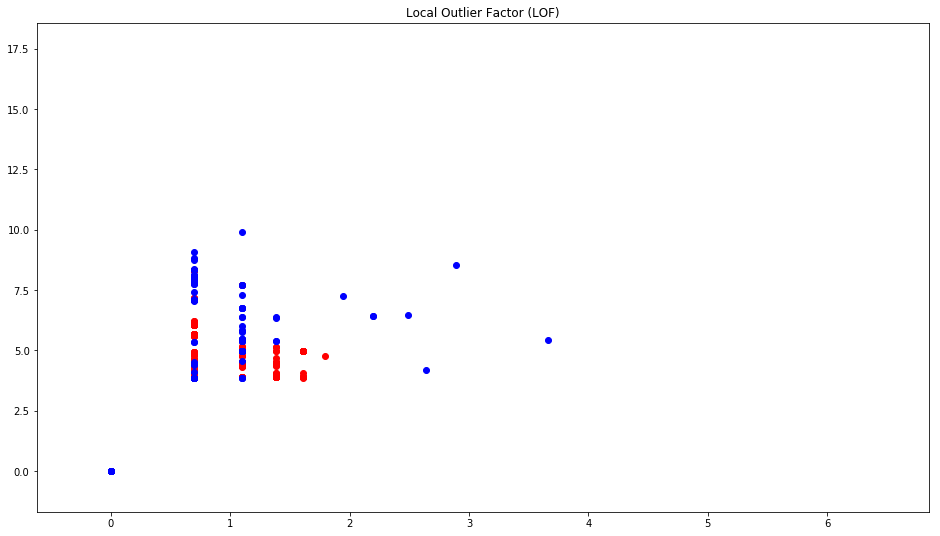

In [84]:
# plot the level sets of the decision function
for data_index in np.where(y_pred == -1)[0]:
    data_point = all_data_N[data_index]
    plt.scatter(data_point[0], data_point[1], c='red')
    
    
for data_index in np.where(y_pred == 1)[0][:500]:
    data_point = all_data_N[data_index]
    plt.scatter(data_point[0], data_point[1], c='blue')
    

"""
a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)"""

plt.title("Local Outlier Factor (LOF)")
plt.axis('tight')
plt.xlim(limits_x)
plt.ylim(limits_y)
plt.show()